# Tm9 Dorso-ventral labeling and 3D to 2D projection

Following scripts uses Tm9 dendritic arbor locations to label each neuron as dorsal or ventral.

In [1]:
#@title Install and import required packages (imports)
# #install Libaries
#!pip install ipympl
#!pip install navis
#!pip3 install fafbseg



In [2]:
#@title import packages
from scipy.optimize import minimize
#import cv2
import numpy as np
import pandas as pd
import os
#from google.colab import files
import io
import math
import matplotlib.pyplot as plt
import navis
from fafbseg import flywire
# %matplotlib widget
from mpl_toolkits.mplot3d import Axes3D
#from google.colab import output
#output.enable_custom_widget_manager()

C:\Users\smolina\Anaconda3\envs\EM\lib\site-packages\blessed\terminal.py:186: UserWarning: Failed to setupterm(kind='xterm-color'): Could not find terminal xterm-color
  warnings.warn(msg)


In [66]:
#@title Upload data
#uploaded = files.upload()
# human_data = pd.read_csv(io.BytesIO(uploaded['bahrami_100.csv']))
#data = pd.read_excel(io.BytesIO(uploaded['Tm9 proofreadings.xlsx']), header=0)

In [18]:
#Path and file
PC_disc = 'D'
dataPath = f'{PC_disc}:\Connectomics-Data\FlyWire\Excels\drive-data-sets\database'
fileName = f'Tm9 proofreadings.xlsx'
filePath = os.path.join(dataPath,fileName)
data = pd.read_excel(filePath)

#Dropping the fisrt row ('asdf' was added as a walk-around to set that column values as type str)
if data["seg_id"][0] == 'asdf': 
    data = data.iloc[1: , :]
    data.reset_index(inplace=True,drop=True)
data.head()

,XYZ-ME,symbol,XYZ-LO,quality comment,Mi4-connected,rim_area (Y/N),hemisphere,lab,author,name,...,optic_lobe_id,patch_id,column_id,backbone proofread (Y/N),twigs proofread (Y/N),inputs_proofread (Y/N),dark_neurons (Y/N),healthy_L3 (Y/N),detached_lamina (Y/N),dorso-ventral
0,"63464.0,83140.0,5499.0",Tm9,"82124.0,73675.0,5135.0",NaN,NaN,?,L,Marion Silies,Sebastian Molina-Obando,"Tm9, Tm9_R, transmedullary neuron Tm9, FBbt_00...",...,L1,V,V1,Y,N,N,NaN,N,?,V
1,"67273.0,85576.0,5497.0",Tm9,"84894.0,75635.0,5033.0",NaN,NaN,?,L,Marion Silies,Jonas Chojetzki,"Tm9, Tm9_R, transmedullary neuron Tm9, FBbt_00...",...,L2,V,V2,Y,Y,Y,?,Y,Y,V
2,"70063.0,88589.0,5760.0",Tm9,"86449.0,78034.0,4816.0",NaN,NaN,?,L,Marion Silies,Sebastian Molina-Obando,"Tm9, Tm9_R, transmedullary neuron Tm9, FBbt_00...",...,L3,V,V3,Y,Y,Y,Y,N,Y,V
3,"65296.0,86194.0,6202.0",Tm9,"81554.0,74784.0,4819.0",NaN,NaN,?,L,Marion Silies,Sebastian Molina-Obando,"Tm9, Tm9_R, transmedullary neuron Tm9, FBbt_00...",...,L4,V,V4,N,N,N,NaN,N,?,V
4,"69273.0,86122.0,4826.0",Tm9,"88273.0,76603.0,5126.0",NaN,NaN,?,L,Marion Silies,Sebastian Molina-Obando,"Tm9, Tm9_R, transmedullary neuron Tm9, FBbt_00...",...,L5,V,V5,Y,N,N,NaN,N,?,V


First, use the neurons in the Left hemisphere

In [19]:
hemisphere = 'R' # 'R', 'L'
neurpile_mesh = 'ME_L'
mesh_azim =16# -18 for ME_R, 16 (600) for ME_L
mesh_elev = -50 # -148 for ME_R, -50 (-489) for ME_L

# ax.azim=-600
# ax.elav=-489


coords = data[data['hemisphere']==hemisphere]['XYZ-ME'].to_numpy(dtype=str, copy=True)
#print(coords)
xyz = np.zeros([np.shape(coords)[0],3])
for idx, coordinate in enumerate(coords):
  xyz[idx,:] = np.array([coordinate.split(',')],dtype=float)
xyz *=[4,4,40] # For plotting it using navis
print(xyz)
print(xyz.shape)

[[728464. 300516.  99360.]
 [724884. 287808. 100920.]
 [760344. 343348. 131240.]
 ...
 [807392. 230616. 163560.]
 [806100. 236020. 161840.]
 [838688. 253888. 222360.]]
(790, 3)


Plot the current points on the medulla.

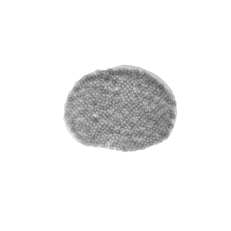

In [20]:
fig = plt.figure()
ax  = fig.add_subplot(projection='3d')
ax.scatter(xyz[:,0],xyz[:,1],xyz[:,2],'.',color=[0,0,0,0.2])
OL_R = flywire.get_neuropil_volumes([neurpile_mesh]) #['ME_R','LO_R','LOP_R']
navis.plot2d([OL_R], method='3d_complex', ax=ax,view=(172, 51),scalebar = '20 um')

ax.azim = mesh_azim
ax.elev = mesh_elev


Project the 3D points onto a 2D plane.

In [21]:
import numpy as np
from scipy.linalg import svd

# Assuming `points` is a Nx3 numpy array representing your points in 3D space
points = xyz
# 1. Fit a plane to the points
# Subtract mean
centroid = np.mean(points, axis=0)
points_centered = points - centroid

# Perform singular value decomposition
_, _, Vt = svd(points_centered)

# The normal to the plane is given by the last column of Vt
normal = Vt[-1, :]

# 2. Project the points onto the fitted plane
# Here, we project the original (centered) points onto the plane
projected_points = points_centered - np.dot(points_centered, normal)[:, None] * normal

# Add the centroid back to the projected points to get them in the original space
projected_points += centroid

Plot the original and projected points.

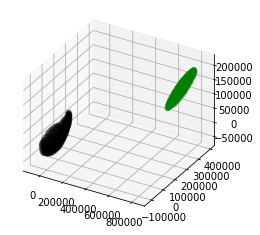

In [22]:
fig = plt.figure()
ax  = fig.add_subplot(projection='3d')
ax.scatter(points_centered[:,0],points_centered[:,1],points_centered[:,2],color=[0,0,0,0.2])# black dots
ax.scatter(normal[0],normal[1],normal[2],color='r')# red dot
ax.scatter(projected_points[:,0],projected_points[:,1],projected_points[:,2],color=[0,0.5,0,0.2]) #green dots


Center the data using the centroid.

[780189.23037975 285083.70632911]


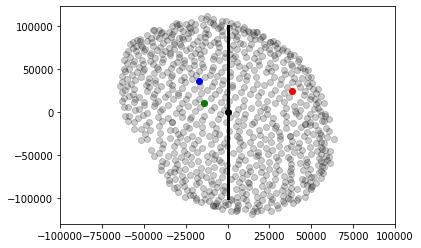

In [23]:
#centroid of the projected points
fig = plt.figure()
xy_ps = projected_points[:,:2]
centroid = projected_points.mean(axis=0)[:2]
shifted_p =  xy_ps- centroid
plt.scatter(shifted_p[:, 0], shifted_p[:, 1],color=[0,0,0,0.2])

#Reference points
plt.scatter(shifted_p[100,0],shifted_p[100,1],color='r')
plt.scatter(shifted_p[105,0],shifted_p[105,1],color='b')
plt.scatter(shifted_p[200,0],shifted_p[200,1],color='g')
plt.scatter(0,0,color='k')

lims = 100000
plt.plot([0,0],[-lims,lims],'k', linewidth=3)
plt.xlim([-lims,lims])
plt.xlim([-lims,lims])

print(centroid)

Rotate 15 degrees to get an orthogonal axis to the dorso-ventral axis.

(-100000.0, 100000.0)

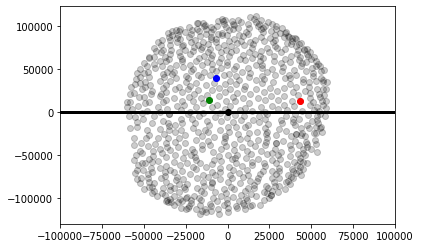

In [38]:
def rotate(origin, points, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    # px, py = point
    px = points[:,0]
    py = points[:,1]

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

fig = plt.figure()

# 15 degrees for 'L' hemisphere
# -15 degrees for 'R' hemisphere
rotated_p = rotate([0,0], shifted_p, math.radians(-15)) # math.radians(15)
rotated_p = np.array(rotated_p).T
plt.scatter(rotated_p[:, 0], rotated_p[:, 1],color=[0,0,0,0.2])

#Reference points
plt.scatter(rotated_p[100,0],rotated_p[100,1],color='r')
plt.scatter(rotated_p[105,0],rotated_p[105,1],color='b')
plt.scatter(rotated_p[200,0],rotated_p[200,1],color='g')
plt.scatter(0,0,color='k')

lims = 100000
plt.plot([-lims,lims],[0,0],'k', linewidth=3)
plt.xlim([-lims,lims])
plt.xlim([-lims,lims])

Label the neurons as dorsal or ventral

In [39]:
labels = np.zeros([rotated_p.shape[0],])
labels[rotated_p[:,1]>0] = 1
labels[rotated_p[:,1]<0] = 2

(-100000.0, 100000.0)

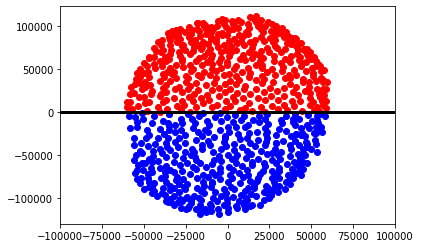

In [40]:
fig = plt.figure()
plt.scatter(rotated_p[labels==1,0],rotated_p[labels==1,1],color='r')
plt.scatter(rotated_p[labels==2,0],rotated_p[labels==2,1],color='b')

lims = 100000
plt.plot([-lims,lims],[0,0],'k', linewidth=3)
plt.xlim([-lims,lims])
plt.xlim([-lims,lims])

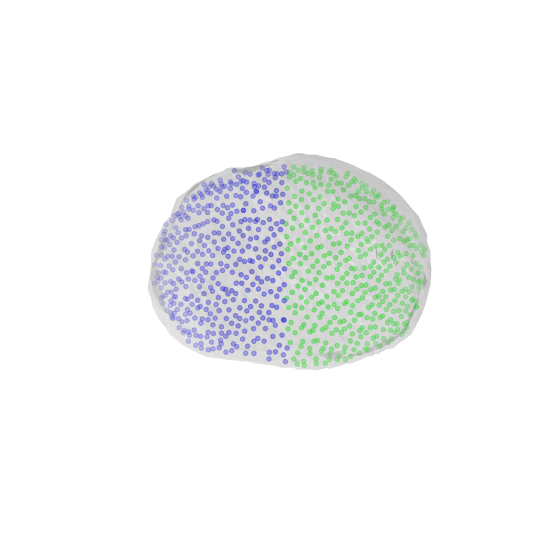

In [41]:
fig = plt.figure(figsize=(10,10))
ax  = fig.add_subplot(projection='3d')
ax.scatter(xyz[labels==1,0],xyz[labels==1,1],xyz[labels==1,2],'.',color=[0,1,0,0.5])
ax.scatter(xyz[labels==2,0],xyz[labels==2,1],xyz[labels==2,2],'.',color=[0,0,1,0.5])


OL_R = flywire.get_neuropil_volumes([neurpile_mesh]) #['ME_R','LO_R','LOP_R']
navis.plot2d([OL_R], method='3d_complex', ax=ax,view=(172, 51),scalebar = '20 um')

ax.azim = mesh_azim
ax.elev = mesh_elev

Add to the dataframe

In [42]:
data.loc[data['hemisphere']==hemisphere, 'dorso-ventral'] = labels

In [43]:
data.loc[data['dorso-ventral']==1.0, 'dorso-ventral'] = 'V'
data.loc[data['dorso-ventral']==2.0, 'dorso-ventral'] = 'D'
data.head()

,XYZ-ME,symbol,XYZ-LO,quality comment,Mi4-connected,rim_area (Y/N),hemisphere,lab,author,name,...,optic_lobe_id,patch_id,column_id,backbone proofread (Y/N),twigs proofread (Y/N),inputs_proofread (Y/N),dark_neurons (Y/N),healthy_L3 (Y/N),detached_lamina (Y/N),dorso-ventral
0,"63464.0,83140.0,5499.0",Tm9,"82124.0,73675.0,5135.0",NaN,NaN,?,L,Marion Silies,Sebastian Molina-Obando,"Tm9, Tm9_R, transmedullary neuron Tm9, FBbt_00...",...,L1,V,V1,Y,N,N,NaN,N,?,V
1,"67273.0,85576.0,5497.0",Tm9,"84894.0,75635.0,5033.0",NaN,NaN,?,L,Marion Silies,Jonas Chojetzki,"Tm9, Tm9_R, transmedullary neuron Tm9, FBbt_00...",...,L2,V,V2,Y,Y,Y,?,Y,Y,V
2,"70063.0,88589.0,5760.0",Tm9,"86449.0,78034.0,4816.0",NaN,NaN,?,L,Marion Silies,Sebastian Molina-Obando,"Tm9, Tm9_R, transmedullary neuron Tm9, FBbt_00...",...,L3,V,V3,Y,Y,Y,Y,N,Y,V
3,"65296.0,86194.0,6202.0",Tm9,"81554.0,74784.0,4819.0",NaN,NaN,?,L,Marion Silies,Sebastian Molina-Obando,"Tm9, Tm9_R, transmedullary neuron Tm9, FBbt_00...",...,L4,V,V4,N,N,N,NaN,N,?,V
4,"69273.0,86122.0,4826.0",Tm9,"88273.0,76603.0,5126.0",NaN,NaN,?,L,Marion Silies,Sebastian Molina-Obando,"Tm9, Tm9_R, transmedullary neuron Tm9, FBbt_00...",...,L5,V,V5,Y,N,N,NaN,N,?,V


In [44]:
# from google.colab import files
# data.to_csv('output.csv', encoding = 'utf-8-sig')
# files.download('output.csv')

Check all the labels

In [45]:
coords = data['XYZ-ME'].to_numpy(dtype=str, copy=True)
d_v = data['dorso-ventral']
xyz = np.zeros([np.shape(coords)[0],3])
for idx, coordinate in enumerate(coords):
  xyz[idx,:] = np.array([coordinate.split(',')],dtype=float)
xyz *=[4,4,40] # For plotting it using navis

Plot the current points on the medulla.

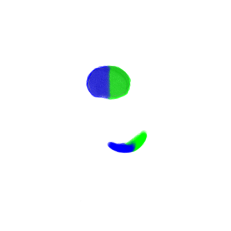

In [46]:
fig = plt.figure()
ax  = fig.add_subplot(projection='3d')
ax.scatter(xyz[d_v=='D',0],xyz[d_v=='D',1],xyz[d_v=='D',2],'.',color=[0,0,1,0.2])
ax.scatter(xyz[d_v=='V',0],xyz[d_v=='V',1],xyz[d_v=='V',2],'.',color=[0,1,0,0.2])

OL_R = flywire.get_neuropil_volumes([neurpile_mesh])
navis.plot2d([OL_R], method='3d_complex', ax=ax,view=(172, 51),scalebar = '20 um')

ax.azim = mesh_azim
ax.elev = mesh_elev

### Saving data back to excel file

In [48]:

# Creating string for the date
import datetime
x = datetime.datetime.now()
date_str = x.strftime("%d") + x.strftime("%b") + x.strftime("%Y")

# Writting in an existing excel file
from openpyxl import load_workbook
book = load_workbook(filePath)
writer = pd.ExcelWriter(filePath, engine = 'openpyxl')
writer.book = book

data.to_excel(writer, sheet_name='Updated_table_'+date_str) #sorted_df
writer.save()
writer.close()

Fitting data to an ellipse

In [55]:
# 3. Fit an ellipse to the projected points
# We'll use the general form of the equation of an ellipse,
# which is Ax^2 + Bxy + Cy^2 + Dx + Ey + F = 0

# First, create a matrix A that contains our variables
X = projected_points[:, 0]
Y = projected_points[:, 1]
A = np.column_stack((X**2, X*Y, Y**2, X, Y, np.ones_like(X)))

# Solve the normal equations A.T * A * a = A.T * b for a
_, _, _, a = np.linalg.lstsq(A, np.ones_like(X), rcond=None)

# The parameters of the ellipse are given by the elements of a
A, B, C, D, E, F = a

In [56]:
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
import numpy as np

In [57]:
def fitEllipse(x,y):
    x = x[:,np.newaxis]
    y = y[:,np.newaxis]
    D = np.hstack((x*x, x*y, y*y, x, y, np.ones_like(x)))
    S = np.dot(D.T, D)
    C = np.zeros([6,6])
    C[0,2] = C[2,0] = 2; C[1,1] = -1
    E, V = np.linalg.eig(np.dot(np.linalg.inv(S), C))
    n = np.argmax(np.abs(E))
    a = V[:,n]
    return a

def ellipse_center(a):
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    num = b*b-a*c
    x0=(c*d-b*f)/num
    y0=(a*f-b*d)/num
    return np.array([x0,y0])

def ellipse_axis_length(a):
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    up = 2*(a*f*f+c*d*d+g*b*b-2*b*d*f-a*c*g)
    down1=(b*b-a*c)*( (c-a)*np.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
    down2=(b*b-a*c)*( (a-c)*np.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
    res1=np.sqrt(up/down1)
    res2=np.sqrt(up/down2)
    return np.array([res1, res2])

def ellipse_angle_of_rotation2(a):
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    if b == 0:
        if a > c:
            return 0
        else:
            return np.pi/2
    else:
        if a > c:
            return np.arctan(2*b/(a-c))/2
        else:
            return np.pi/2 + np.arctan(2*b/(a-c))/2


In [58]:
# def plot_ellipse(x, y):
#     a = fitEllipse(x, y)

#     center = ellipse_center(a)

#     phi = ellipse_angle_of_rotation2(a)

#     axes = ellipse_axis_length(a)

#     a, b = axes

#     ell = Ellipse(center, 2*a, 2*b, phi*180 / np.pi, facecolor=(0,0,0,0.2), edgecolor=(0,0,0,0.5))

#     ell_rotated = Ellipse(center, 2*a, 2*b, phi*180 / np.pi + 90, facecolor=(0,0,1,0.2), edgecolor=(0,0,0))
def plot_ellipse(x, y):
    a = fitEllipse(x, y)

    center = ellipse_center(a)

    phi = ellipse_angle_of_rotation2(a)

    axes = ellipse_axis_length(a)

    a, b = axes

    ell = Ellipse(center, 2*a, 2*b, phi*180 / np.pi, facecolor=(0,0,0,0.2), edgecolor=(0,0,0,0.5))

    ell_rotated = Ellipse(center, 2*a, 2*b, phi*180 / np.pi + 90, facecolor=(0,0,0,0.2), edgecolor=(0,0,0,0.5))

    fig, ax = plt.subplots()
    ax.add_patch(ell)
    ax.add_patch(ell_rotated)

    plt.scatter(x, y,color=[0,0,0,0.5])

    plt.show()

    return [ell, axes, center]

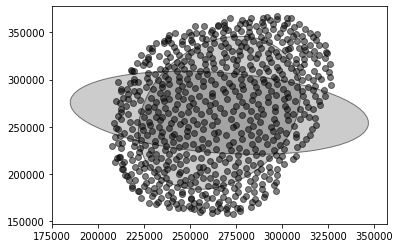

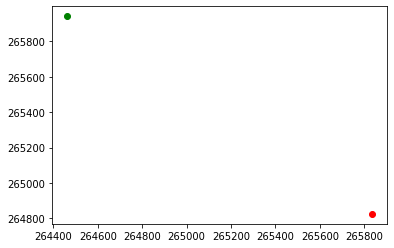

In [59]:
ellipse_m = plot_ellipse(projected_points[:, 0], projected_points[:, 1])
# plt.scatter(projected_points[100,0],projected_points[100,1],color='r')
# plt.scatter(projected_points[105,0],projected_points[105,1],color='b')
# plt.scatter(projected_points[200,0],projected_points[200,1],color='g')
plt.scatter(ellipse_m[2][0],ellipse_m[2][1],color='r', label='ellipse center')
plt.scatter(projected_points[:,0].mean(),projected_points[:,1].mean(),color='g', label='centroid')